In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from matplotlib import pyplot as plt
from feat_desc import *
import cv2
import numpy as np
from corner_detector import *
from anms import *
from feat_match import *
from ransac_est_homography import *
from scipy import ndimage

max_anms=4000

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
img1=cv2.imread('images/small-middle.jpg')
gray = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
c = corner_detector(gray)
print(np.sum(c>0))
X1,Y1,rmax=anms(c, max_anms)
d1 = feat_desc(gray,X1,Y1)
kp1=[]
for (_x,_y) in zip(X1,Y1):
    kp1.append(cv2.KeyPoint(_x,_y,40))


30178


In [7]:
img2=cv2.imread('images/small-right.jpg')
gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
c = corner_detector(gray)
print(np.sum(c>0))
X2,Y2,rmax=anms(c, max_anms)
d2 = feat_desc(gray,X2,Y2)
print("Rmax" + str(rmax))
kp2=[]
for (_x,_y) in zip(X2,Y2):
    kp2.append(cv2.KeyPoint(_x,_y,40))


37746
Rmax6.082762530298219


In [8]:
m,dMatch=feat_match(d1, d2)
x1=[]
y1=[]
x2=[]
y2=[]

for k,idx in enumerate(m):
    if (idx != -1):
        x1.append(X1[k])
        y1.append(Y1[k])
        x2.append(X2[idx])
        y2.append(Y2[idx])
x1=np.array(x1)
x2=np.array(x2)
y1=np.array(y1)
y2=np.array(y2)
print(x1.shape)


(22,)


In [10]:
H, inlier_ind=ransac_est_homography(x1,y1,x2,y2,2)

Norm:-  [[-1.33724756e-02 -6.10740251e-01  3.64137024e+02]
 [-1.75100074e-02 -5.19132417e-01  3.12532247e+02]
 [-3.73886428e-05 -1.67501375e-03  1.00000000e+00]]
8593.830128624126
Norm:-  [[-8.71325363e-01 -2.39789328e-01  4.46308387e+02]
 [-1.30660073e+00 -1.80691193e-01  5.72964223e+02]
 [-2.14993802e-03 -3.94683476e-04  1.00000000e+00]]
5280.932461491223
Norm:-  [[-2.12917586e-01 -5.28767266e-01  3.74707178e+02]
 [-6.26053439e-01 -9.43817746e-01  7.02038526e+02]
 [-1.01693632e-03 -1.29534332e-03  1.00000000e+00]]
3991.203443100674
Norm:-  [[-4.05005390e-01 -2.12256769e-01  2.37739347e+02]
 [-2.22631091e-01 -1.64612216e+00  8.45667913e+02]
 [-3.61438473e-04 -2.04093047e-03  1.00000000e+00]]
29427.62804174226
Norm:-  [[ 2.97758493e+01 -2.05833766e-02 -8.24110391e+03]
 [ 2.06260458e+01  3.48494449e+01 -1.28029529e+04]
 [ 3.28171309e-02  2.00465766e-02  1.00000000e+00]]
2831.3655243748212
Norm:-  [[ 2.72366505e-01 -1.11328314e-01 -6.23630471e+00]
 [-6.46239059e-01 -1.27290905e-01  4.654

(1800, 2133, 3)


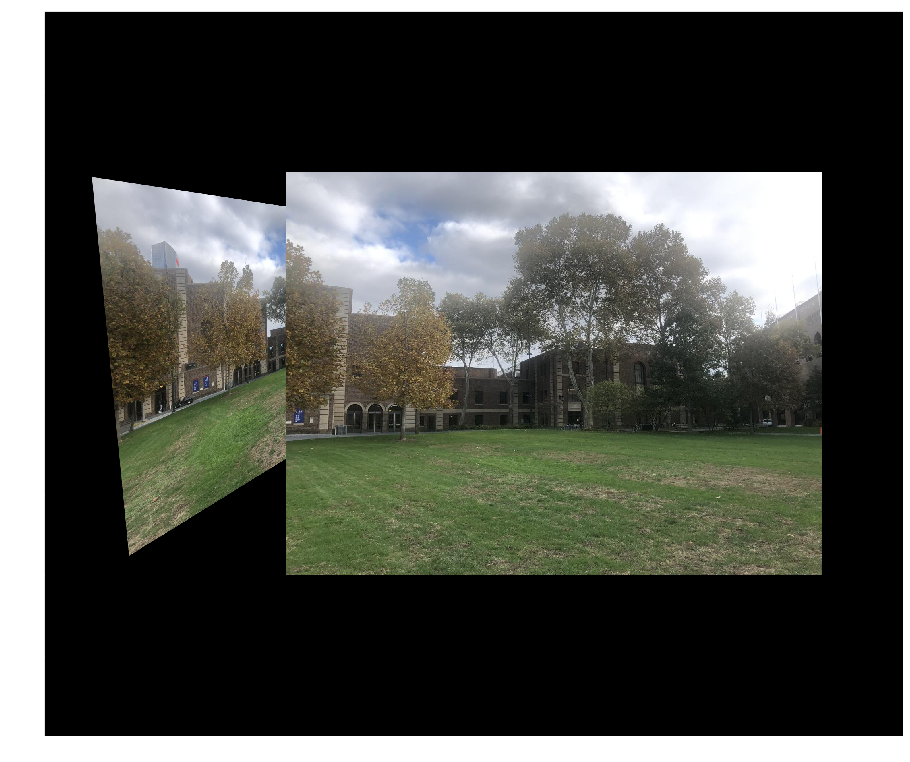

True

In [11]:

border = 400
paddedImage = cv2.copyMakeBorder(img1, border, border, border, border,cv2.BORDER_CONSTANT)

result = cv2.warpPerspective(paddedImage, H,(int(paddedImage.shape[1]), int(paddedImage.shape[0])))
pad = 200
result[border:border+img2.shape[0],border+pad:border+pad+img2.shape[1]] = img2
print(result.shape)
fig=plt.figure(figsize=(16, 12), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.show()
cv2.imwrite("res.png",result)



9


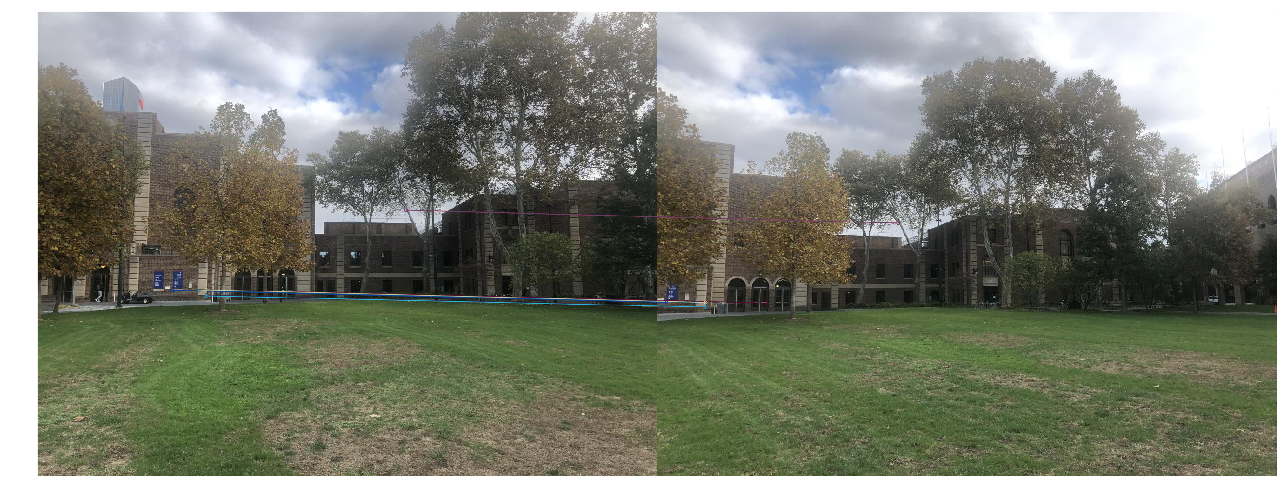

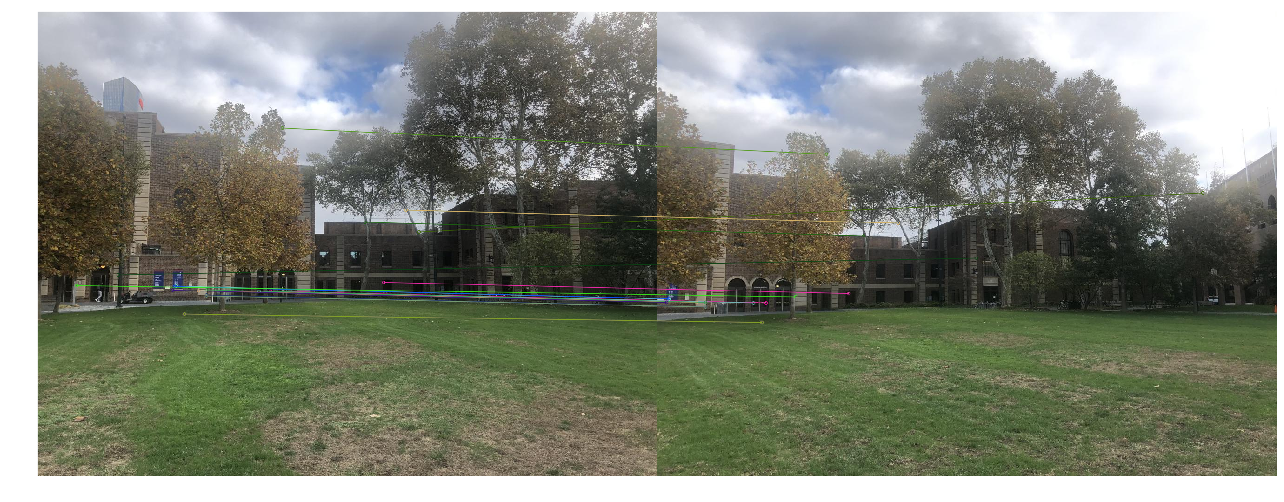

In [16]:
mask = np.array(inlier_ind, dtype=bool)

mfilter = []
for idx,i in enumerate(mask):
    if i == True:
        mfilter.append(dMatch[idx])
img_matches = np.empty((max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1], 3), dtype=np.uint8)
print(len(mfilter))
f=cv2.drawMatches(img1, kp1, img2, kp2, mfilter, img_matches, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
fig=plt.figure(figsize=(20, 18), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.show()
f=cv2.drawMatches(img1, kp1, img2, kp2, dMatch, img_matches, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
fig=plt.figure(figsize=(20, 18), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.show()

In [17]:
a = np.arange(12.).reshape((4, 3))
print(a)


[[ 0.  1.  2.]
 [ 3.  4.  5.]
 [ 6.  7.  8.]
 [ 9. 10. 11.]]


In [18]:
def panorama(H,fromim,toim,padding=2400,delta=2400):
    """ Create horizontal panorama by blending two images 
        using a homography H (preferably estimated using RANSAC).
        The result is an image with the same height as toim. 'padding' 
        specifies number of fill pixels and 'delta' additional translation. """
     
    # check if images are grayscale or color
    is_color = len(fromim.shape) == 3
     
    # homography transformation for geometric_transform()
    def transf(p):
        p2 = dot(H,[p[0],p[1],1])
        return (p2[0]/p2[2],p2[1]/p2[2])
     
    if H[1,2]<0: # fromim is to the right
        print('warp - right')
        # transform fromim
        if is_color:
            # pad the destination image with zeros to the right
            toim_t = hstack((toim,zeros((toim.shape[0],padding,3))))
            fromim_t = zeros((toim.shape[0],toim.shape[1]+padding,toim.shape[2]))
            for col in range(3):
                fromim_t[:,:,col] = ndimage.geometric_transform(fromim[:,:,col],
                                        transf,(toim.shape[0],toim.shape[1]+padding))
        else:
            # pad the destination image with zeros to the right
            toim_t = hstack((toim,zeros((toim.shape[0],padding))))
            fromim_t = ndimage.geometric_transform(fromim,transf,
                                    (toim.shape[0],toim.shape[1]+padding)) 
    else:
        print('warp - left')
        # add translation to compensate for padding to the left
        H_delta = array([[1,0,0],[0,1,-delta],[0,0,1]])
        H = dot(H,H_delta)
        # transform fromim
        if is_color:
            # pad the destination image with zeros to the left
            toim_t = hstack((zeros((toim.shape[0],padding,3)),toim))
            fromim_t = zeros((toim.shape[0],toim.shape[1]+padding,toim.shape[2]))
            for col in range(3):
                fromim_t[:,:,col] = ndimage.geometric_transform(fromim[:,:,col],
                                            transf,(toim.shape[0],toim.shape[1]+padding))
        else:
            # pad the destination image with zeros to the left
            toim_t = hstack((zeros((toim.shape[0],padding)),toim))
            fromim_t = ndimage.geometric_transform(fromim,
                                    transf,(toim.shape[0],toim.shape[1]+padding))
     
    # blend and return (put fromim above toim)
    if is_color:
        # all non black pixels
        alpha = ((fromim_t[:,:,0] * fromim_t[:,:,1] * fromim_t[:,:,2] ) > 0)
        for col in range(3):
            toim_t[:,:,col] = fromim_t[:,:,col]*alpha + toim_t[:,:,col]*(1-alpha)
    else:
        alpha = (fromim_t > 0)
        toim_t = fromim_t*alpha + toim_t*(1-alpha)
     
    return toim_t

In [19]:
res=panorama(H,img1,img2)

warp - left


NameError: name 'array' is not defined

In [0]:
print(res.shape)

In [0]:
h1 = img1.shape[0]
h2 = img2.shape[0]
w1 = img1.shape[1]
w2 = img2.shape[1]
vis = np.zeros((max(h1, h2), w1+w2,3), np.uint8)

#combine 2 images
vis[:h1, :w1,:3] = img1
vis[:h2, w1:w1+w2,:3] = img2

In [0]:
fig=plt.figure(figsize=(16, 12), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))